In [11]:
import os
import sys
from parselmouth import Sound
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


cwd = os.getcwd()
print(cwd)
sys.path.insert(0, os.path.abspath(os.path.dirname(cwd)))

import phonlab as phon

import importlib
importlib.reload(phon)

#from phon import tg_to_df, add_context, merge_tiers, explode_intervals, interpolate_measures, loadsig

/Users/kjohnson/Documents/phonlab/examples


<module 'phonlab' from '/Users/kjohnson/Documents/phonlab/phonlab/__init__.py'>

In [12]:
au, rate = phon.loadsig('loadsig/mono.wav')

In [4]:
phdf, wddf = phon.tg_to_df('mono.TextGrid', tiersel=['phone', 'word'])
phdf = phon.add_context(phdf, 'phone', nprev=2, nnext=2, ctxcol='phonectx')
wddf = phon.add_context(wddf, 'word', nprev=1, nnext=0, ctxcol='wdctx')
phwddf = phon.merge_tiers(inner_df=phdf, outer_df=wddf, suffixes=['_ph', '_wd'])
vowels = ['ai', 'e', 'a', 'au']
vdf = phwddf.query(f'phone in {vowels}')
vdf

AttributeError: module 'phonlab' has no attribute 'tg_to_df'

In [4]:
vdf = explode_intervals([0.25, 0.50, 0.75], ts=['t1_ph', 't2_ph'], df=vdf)
vdf

,t1_ph,t2_ph,prev_phone2,prev_phone1,phone,next_phone1,next_phone2,phonectx,t1_wd,t2_wd,prev_word1,word,wdctx,obs_t,obs_id
0,0.000000,0.126541,,,ai,m,t,ai t m,0.000000,0.213045,,I'm,I'm,0.031635,0.25
0,0.000000,0.126541,,,ai,m,t,ai t m,0.000000,0.213045,,I'm,I'm,0.063271,0.50
0,0.000000,0.126541,,,ai,m,t,ai t m,0.000000,0.213045,,I'm,I'm,0.094906,0.75
4,0.470892,0.598984,t,w,e,l,v,w t e v l,0.213045,0.885111,I'm,twelve,I'm twelve,0.502915,0.25
4,0.470892,0.598984,t,w,e,l,v,w t e v l,0.213045,0.885111,I'm,twelve,I'm twelve,0.534938,0.50
4,0.470892,0.598984,t,w,e,l,v,w t e v l,0.213045,0.885111,I'm,twelve,I'm twelve,0.566961,0.75
9,1.405795,1.592111,,t,a,k,N,t a N k,1.264395,1.724744,we've,talking,we've talking,1.452374,0.25
9,1.405795,1.592111,,t,a,k,N,t a N k,1.264395,1.724744,we've,talking,we've talking,1.498953,0.50
9,1.405795,1.592111,,t,a,k,N,t a N k,1.264395,1.724744,we've,talking,we've talking,1.545532,0.75
12,1.724744,1.788813,k,N,a,b,au,N k a au b,1.724744,1.998125,talking,about,talking about,1.740762,0.25


## Generic df interface

Establish a pattern for easily getting values from **any** time-based dataframe of measurements.

First, create a dataframe of this type as a proof of concept. The `tcol` column has time values, and `genf1` and `genf2` are values for F1 and F2. The `foo` column is added as a nonce column of a non-numeric type.

In [5]:
gendf = pd.read_csv('generic_formant.csv')
gendf

,tcol,f1,f2,foo
0,0.027187,993.279286,1492.845320,nonce
1,0.033437,1034.390408,1469.361084,nonce
2,0.039687,1040.824979,1444.246084,nonce
3,0.045937,1051.933204,1439.744705,nonce
4,0.052187,1057.320050,1436.092433,nonce
...,...,...,...,...
307,1.945938,729.259123,1142.790641,nonce
308,1.952187,694.972178,1064.015901,nonce
309,1.958438,682.759568,1070.449201,nonce
310,1.964687,653.720818,1048.153592,nonce


The `vdf` dataframe has metadata for vowels and was already used to get `f1` and `f2` values by using a praat-specific function (`praatformant_to_df`) on a parselmouth Formant object.

The `interpolate_measures` function takes a measurement df `measdf` that contains a time column specified by the `meas_ts` parameter. Notice that we take a subset of `gendf` when setting the `measdf` parameter, as non-numeric columns cannot be interpolated and raise an error.

The `interpdf` parameter is used to specify the dataframe that has times for which measures from `measdf` are interpolated. The name of the column containing the times to be interpolated is specified by the `interp_ts` parameter value.

In [6]:
vdf = interpolate_measures(
    meas_df=gendf[['tcol', 'f1', 'f2']],  # tcol + cols to interpolate only
    meas_ts='tcol',
    interp_df=vdf,
    interp_ts='obs_t'
)
vdf

,t1_ph,t2_ph,prev_phone2,prev_phone1,phone,next_phone1,next_phone2,phonectx,t1_wd,t2_wd,prev_word1,word,wdctx,obs_t,obs_id,f1,f2
0,0.000000,0.126541,,,ai,m,t,ai t m,0.000000,0.213045,,I'm,I'm,0.031635,0.25,1022.536276,1476.132615
0,0.000000,0.126541,,,ai,m,t,ai t m,0.000000,0.213045,,I'm,I'm,0.063271,0.50,1091.321439,1462.187126
0,0.000000,0.126541,,,ai,m,t,ai t m,0.000000,0.213045,,I'm,I'm,0.094906,0.75,1036.754664,1735.949970
4,0.470892,0.598984,t,w,e,l,v,w t e v l,0.213045,0.885111,I'm,twelve,I'm twelve,0.502915,0.25,763.229407,1374.881740
4,0.470892,0.598984,t,w,e,l,v,w t e v l,0.213045,0.885111,I'm,twelve,I'm twelve,0.534938,0.50,758.892479,1352.497217
4,0.470892,0.598984,t,w,e,l,v,w t e v l,0.213045,0.885111,I'm,twelve,I'm twelve,0.566961,0.75,737.756447,1272.869230
9,1.405795,1.592111,,t,a,k,N,t a N k,1.264395,1.724744,we've,talking,we've talking,1.452374,0.25,937.359137,1228.616727
9,1.405795,1.592111,,t,a,k,N,t a N k,1.264395,1.724744,we've,talking,we've talking,1.498953,0.50,1017.272205,1314.589402
9,1.405795,1.592111,,t,a,k,N,t a N k,1.264395,1.724744,we've,talking,we've talking,1.545532,0.75,1126.288915,1543.485070
12,1.724744,1.788813,k,N,a,b,au,N k a au b,1.724744,1.998125,talking,about,talking about,1.740762,0.25,399.347076,1537.990305


The `interpolate_measures` function does linear interpolation, and its values are quite similar to the `f1` and `f2` values retrieved via parselmouth.

F1 and F2 plots showing all measures and interpolated values at 25%, 50%, 75%.

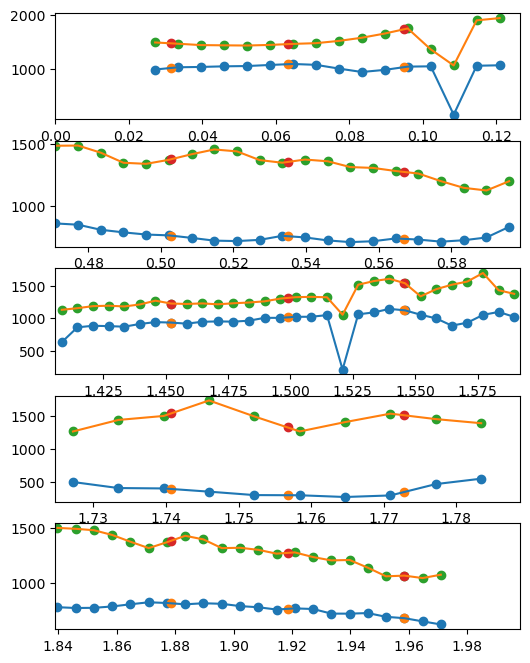

In [7]:
fig, axes = plt.subplots(5, 1, figsize=[6, 8])
for i, (_, g) in enumerate(vdf.groupby('t1_ph')):
    t1 = g['t1_ph'].iloc[0]
    t2 = g['t2_ph'].iloc[0]
    mdf = gendf.query(f'(tcol >= {t1}) and (tcol <= {t2})')
    for col in ('f1', 'f2'):
        axes[i].plot(mdf['tcol'], mdf[col])
        axes[i].scatter(mdf['tcol'], mdf[col])
        axes[i].scatter(g['obs_t'], g[col])
        axes[i].set_xlim([t1, t2])